In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

In [2]:
Z_DIM = 6
OUT_DIM = 4
REAL_LABEL = 1
FAKE_LABEL = 0
n_epoch = 25
lr = 6e-4
batch_size = 64

d_lr = lr
g_lr = lr

seed = 42

name = "classical-gan-1.5.2"

save_folder = f"saved/{name}"

data_path = "dataset/dataset.npy"

In [3]:
## some code to prevent the the output from being saved to the wrong directory

if globals().get("__file__") and os.path.basename(globals["__file__"]) != name + ".py":
    raise UserWarning("The 'name' variable does not match the file name.")
if globals().get("__vsc_ipynb_file__") and os.path.basename(globals().get("__vsc_ipynb_file__")) != name + ".ipynb":
    raise UserWarning("The 'name' variable does not match the file name.")

In [4]:
if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

rng = np.random.default_rng()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# torch.manual_seed(seed)
# torch.use_deterministic_algorithms(True) 

This notebook may overwrite previous results in the saved/classical-gan-1.5.2 directory


In [5]:
np.load(data_path)

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

In [6]:
data_true = np.load(data_path)
rng.shuffle(data_true)
data_true = torch.tensor(data_true, dtype = torch.float32, device=device, requires_grad=False)
data_loader = torch.utils.data.DataLoader(data_true, batch_size=batch_size, shuffle = True)

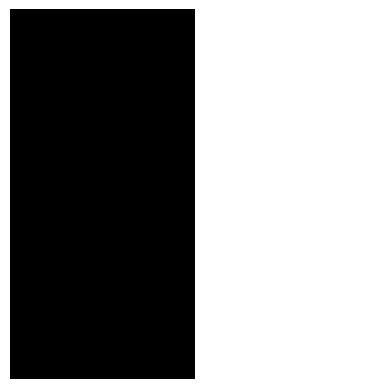

In [7]:
real_batch = next(iter(data_loader))
real_sample_one = real_batch[0]
plt.figure()
plt.axis("off")
plt.imshow(real_sample_one.reshape(2, 2).cpu(), cmap="binary")

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.5)
        m.bias.data.uniform_(-0.3, 0.3)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(Z_DIM, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 12),
            nn.LeakyReLU(0.2),
            nn.Linear(12, OUT_DIM),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 12),
            nn.LeakyReLU(0.2),
            # nn.Linear(16, 8),
            # nn.LeakyReLU(0.2),
            nn.Linear(12, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=8, out_features=12, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=12, out_features=4, bias=True)
    (5): Sigmoid()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(0.5, 0.999))

In [13]:
for param in netD.parameters():
    print(param.data)

tensor([[-0.3962,  0.6266,  0.2718,  0.4560],
        [-0.1448,  0.0756,  0.8639, -0.0624],
        [-0.3305, -0.1755,  0.0025,  0.4418],
        [-0.5853,  1.1329,  0.1238,  0.7562],
        [-0.0550, -0.6903,  0.0742, -0.4970],
        [ 0.2564,  0.3609, -0.0420, -0.1776],
        [ 0.3374, -0.2222, -0.3660, -0.4533],
        [-0.0111,  0.1135, -0.3948, -1.0342],
        [ 0.1003,  0.1621, -0.0456, -0.9607],
        [-0.1384,  0.0531,  0.0332, -0.4279],
        [ 0.5383, -0.8107,  0.8531, -0.6047],
        [ 0.3690, -0.1988, -0.5517,  0.3344]], device='cuda:0')
tensor([-0.1805, -0.0049,  0.2629,  0.2147,  0.0625,  0.2254,  0.1275, -0.0367,
         0.0361, -0.0058,  0.1367,  0.0659], device='cuda:0')
tensor([[-0.5105, -0.4889,  0.0859, -0.1302, -0.4537,  0.1812,  0.1812, -0.0386,
         -0.3859,  1.0114,  0.0257, -0.2654],
        [ 0.6947,  0.8530,  1.3751,  0.5315, -0.6806, -0.3089,  0.0710,  0.1826,
          0.7652, -0.4544, -0.1220, -0.6275],
        [ 0.1165, -0.2941, -0.4939

In [14]:
for param in netG.parameters():
    print(param.data)

tensor([[-1.0780,  0.3539,  0.3229,  0.3784,  0.0623, -0.0184],
        [-0.1677,  0.1400, -0.2780, -0.7249, -0.5781, -0.1599],
        [ 0.2925, -0.6007, -0.2782,  0.5046,  0.2611, -0.4085],
        [-0.5997, -0.0407, -0.2341,  0.0555,  0.5833,  0.1071],
        [ 0.1895, -0.0530, -0.8841, -0.4573, -0.7625, -0.2015],
        [-0.7318, -0.4455,  0.0471,  0.0470,  0.3046, -0.5526],
        [ 0.1000,  0.9424,  0.9669,  0.2987, -0.1658, -0.2665],
        [ 0.6765, -0.1471, -0.8259, -0.2270,  0.1368,  0.0287]],
       device='cuda:0')
tensor([ 0.1653, -0.1849, -0.1849, -0.1217,  0.0278, -0.1234,  0.1881,  0.1505],
       device='cuda:0')
tensor([[-0.2423,  0.4113,  0.3815,  0.6715, -0.8923,  0.4068, -0.3119,  0.0188],
        [ 0.6698, -0.2489,  0.4162,  1.0629, -0.5570, -0.4356, -0.0550,  0.1405],
        [-0.1616,  0.5875, -0.6942,  0.1947, -1.1313,  0.0387, -0.8194,  0.7886],
        [ 0.3962,  0.3733,  0.4519,  0.2357,  0.1641,  0.2993,  0.3016,  0.2220],
        [-0.3877,  0.3228,  0.

In [15]:
G_losses = []
D_losses = []
iters = 0

netD.train()
netG.train()

print("Starting Training Loop...")

for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):

        netD.zero_grad()
        real_batch = data.to(device)
        b_size = real_batch.shape[0]
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        output = netD(real_batch).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, Z_DIM, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(REAL_LABEL)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 50 == 0:
            print(f"[{epoch}/{n_epoch}][{i}/{len(data_loader)}]\tLossD: {errD.item():.4f}\tLossG: {errG.item():.4f}\t" +
                f"D(x): {D_x:.4f}\tD(G(x)): {D_G_z2:.4f}")



Starting Training Loop...
[0/25][0/320]	LossD: 1.5954	LossG: 0.5671	D(x): 0.4763	D(G(x)): 0.5694
[0/25][50/320]	LossD: 1.5439	LossG: 0.5710	D(x): 0.4941	D(G(x)): 0.5656
[0/25][100/320]	LossD: 1.4750	LossG: 0.6242	D(x): 0.4946	D(G(x)): 0.5359
[0/25][150/320]	LossD: 1.4173	LossG: 0.6758	D(x): 0.4945	D(G(x)): 0.5088
[0/25][200/320]	LossD: 1.3612	LossG: 0.7225	D(x): 0.4999	D(G(x)): 0.4856
[0/25][250/320]	LossD: 1.2046	LossG: 0.7595	D(x): 0.5716	D(G(x)): 0.4679
[0/25][300/320]	LossD: 1.0750	LossG: 0.7788	D(x): 0.6461	D(G(x)): 0.4603
[1/25][0/320]	LossD: 1.1028	LossG: 0.7481	D(x): 0.6648	D(G(x)): 0.4808
[1/25][50/320]	LossD: 1.4292	LossG: 0.6596	D(x): 0.5301	D(G(x)): 0.5245
[1/25][100/320]	LossD: 1.4807	LossG: 0.6842	D(x): 0.4723	D(G(x)): 0.5058
[1/25][150/320]	LossD: 1.4626	LossG: 0.7471	D(x): 0.4431	D(G(x)): 0.4739
[1/25][200/320]	LossD: 1.3980	LossG: 0.7826	D(x): 0.4555	D(G(x)): 0.4572
[1/25][250/320]	LossD: 1.3207	LossG: 0.8144	D(x): 0.4819	D(G(x)): 0.4430
[1/25][300/320]	LossD: 1.3416	L

In [16]:
for param in netD.parameters():
    print(param.data)

tensor([[-5.3276e-01,  9.1472e-01,  5.3411e-01, -3.3505e-03],
        [ 3.0480e-03, -4.0575e-02,  8.6124e-01, -5.9506e-01],
        [-1.3398e+00, -3.4879e-01, -8.4957e-01,  1.3814e-01],
        [-9.1502e-01,  1.0280e+00, -2.0630e-01,  5.4629e-01],
        [-1.5094e-01, -5.0518e-01, -6.5029e-02, -8.5390e-01],
        [ 4.2480e-01,  7.3199e-01,  1.6046e-03, -2.8829e-01],
        [ 2.8010e-01, -4.3737e-01, -3.1383e-01, -1.8568e+00],
        [-1.6534e-01,  2.1386e-01, -8.2231e-01, -1.7203e+00],
        [ 4.3499e-01,  2.4905e-01,  1.6704e-01, -9.7403e-01],
        [ 2.0222e-01, -3.4182e-01,  4.0299e-01,  5.8160e-02],
        [ 8.9478e-01, -9.8628e-01,  1.1372e+00, -2.0351e-01],
        [-8.9881e-02, -1.4938e-01, -7.7218e-01,  4.7012e-01]], device='cuda:0')
tensor([ 3.9135e-05, -2.4273e-01,  5.2654e-01, -2.3517e-01, -4.4853e-03,
         9.1506e-01,  5.5215e-01, -2.3023e-01,  3.7054e-01,  7.3110e-02,
        -5.6893e-01, -2.5830e-01], device='cuda:0')
tensor([[-8.6723e-01, -3.7808e-01,  9.01

In [17]:
for param in netG.parameters():
    print(param.data)

tensor([[-1.1616,  0.9009,  0.9999,  0.7180,  0.0961,  0.2454],
        [ 0.4823,  0.1771, -0.4922, -1.5128, -1.4274,  0.1533],
        [ 0.5470, -0.8503, -0.1837,  1.1094,  0.8754, -0.5060],
        [-1.3076, -0.6540, -0.6307,  0.2096,  1.4385,  0.2451],
        [ 0.3613, -0.0781, -0.6254, -0.7568, -0.7348,  0.1395],
        [-1.1331, -1.2298, -0.5522,  0.2428,  0.9229, -0.7651],
        [ 0.5412,  1.9013,  2.0282,  0.5980, -0.5240,  0.0477],
        [ 0.9933, -0.7170, -1.3862, -0.7548, -0.4756,  0.2166]],
       device='cuda:0')
tensor([ 0.9400,  0.1894,  0.3376,  0.6917, -0.2535,  0.6213,  0.9659,  0.7285],
       device='cuda:0')
tensor([[ 0.5667, -0.0806,  0.9260,  1.1271, -1.4736,  0.8137,  0.6531, -0.0616],
        [ 0.6778,  0.4761,  0.0660,  0.5483,  0.1334, -0.6496,  0.3597,  0.8636],
        [ 0.0208,  0.8231,  0.0435,  0.9409, -0.7828,  1.0803, -2.2522,  1.0901],
        [ 0.2111, -0.0373,  0.3541,  0.4634,  0.0210,  0.8075, -0.4358,  0.2541],
        [ 0.5370,  0.5164,  0.

In [18]:
netD.eval()
netG.eval()

Generator(
  (main): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=8, out_features=12, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=12, out_features=4, bias=True)
    (5): Sigmoid()
  )
)

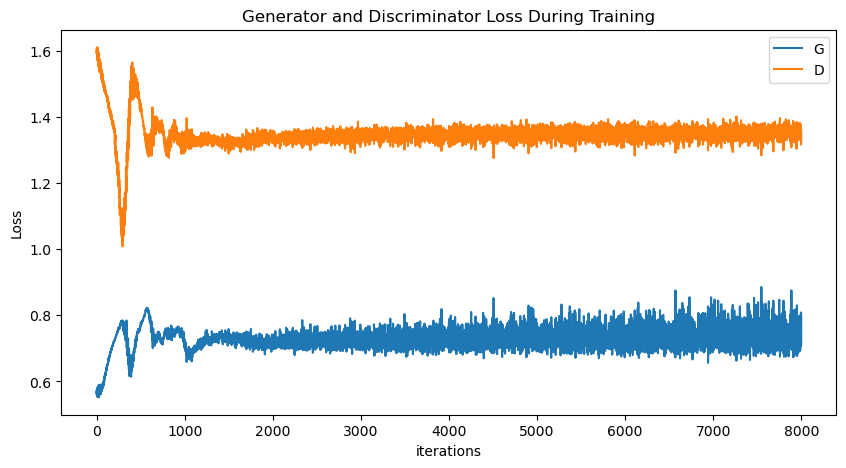

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
n_rows = 4
n_cols = 4

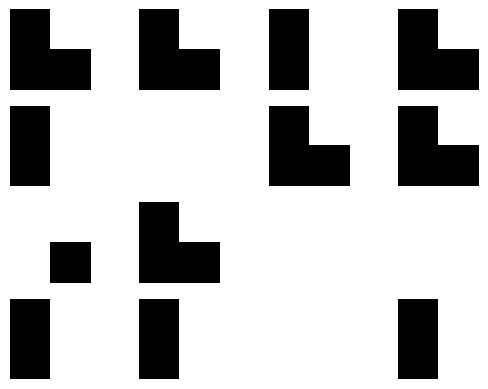

In [21]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

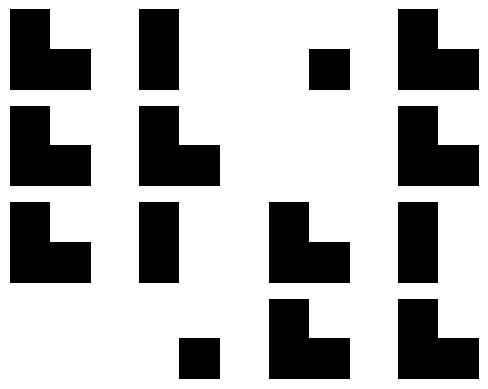

In [22]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

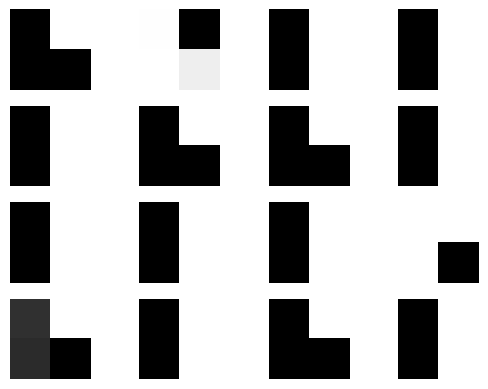

In [23]:
b_size = n_rows * n_cols

noise = torch.randn(b_size, Z_DIM, device=device)

with torch.no_grad():
    fake_batch = netG(noise)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2).cpu(), cmap="binary")

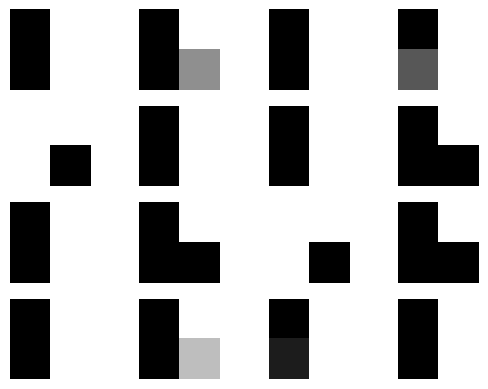

In [24]:
b_size = n_rows * n_cols

noise = torch.randn(b_size, Z_DIM, device=device)

with torch.no_grad():
    fake_batch = netG(noise)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2).cpu(), cmap="binary")

In [25]:
sample_size = 10000
data_index = torch.randperm(data_true.shape[0])[:sample_size]
real_samples = data_true[data_index]



noise = torch.randn(sample_size, Z_DIM, device=device)
with torch.no_grad():
    fake_samples = netG(noise)


np.savez(save_folder + "/samples.npz", 
    real_samples = real_samples.cpu(), 
    fake_samples_raw=fake_samples.cpu())

In [26]:
with torch.no_grad():
    real_scores = netD(real_samples).cpu()
    fake_scores = netD(fake_samples).cpu()
    # fake_rounded_scores = netD(fake_samples_rounded).cpu()

In [27]:
print(np.mean(real_scores.numpy()))
print(np.mean(fake_scores.numpy()))
# print(np.mean(fake_rounded_scores.numpy()))

0.5271643
0.50650245


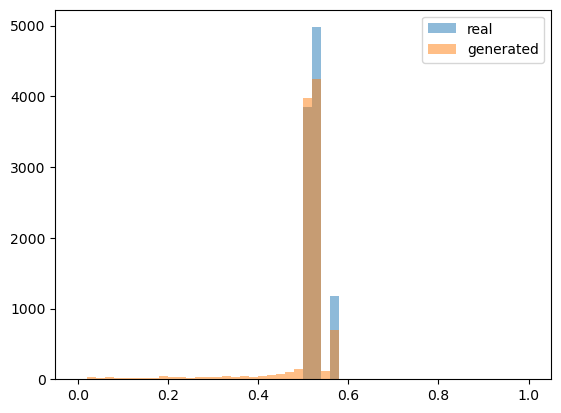

In [28]:
fig, ax = plt.subplots()



ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha = 0.5, label="real")
ax.hist(fake_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha = 0.5, label="generated")

ax.legend()

None

In [29]:
# fig, ax = plt.subplots()



# ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), alpha=0.5, color = plt.cm.tab10(0))
# ax.hist(fake_rounded_scores.view(-1), bins = 50, range=(0, 1), alpha=0.5, color = plt.cm.tab10(1))

# None

In [30]:
json_path = data_path[:-4] + ".json"
with open(json_path, 'r') as f:
    real_data_dict = json.load(f)

def np_to_dict(result_np):
    result_dict = {}
    for line in result_np:
        str_key = ""
        for i in line:  # reversing the order to match qiskit notation
            str_key+=(str(i))
        current_value = result_dict.get(str_key, 0)
        result_dict[str_key] = current_value + 1
    return result_dict

noise = torch.randn(20480, Z_DIM, device=device)
with torch.no_grad():
    fake_data_raw = netG(noise)
fake_data_rounded = torch.round(fake_data_raw)
fake_data_rounded = fake_data_rounded.cpu().numpy().astype(np.int32)


fake_data_dict = np_to_dict(fake_data_rounded)

all_keys = (set(real_data_dict.keys())) | (set(fake_data_dict.keys()))

real_counts = []
fake_counts = []

for k in all_keys:
    real_counts.append(real_data_dict.get(k, 0))
    fake_counts.append(fake_data_dict.get(k, 0))

real_counts = np.array(real_counts)
fake_counts = np.array(fake_counts)

real_probs = real_counts / np.sum(real_counts)
fake_probs = fake_counts / np.sum(fake_counts)

mixed_probs = (real_probs + fake_probs) / 2 # here, every entry of mixed_probs are positive

# Note, mixed_probs is all positive. That's why you can use nan_to_num to deal with zero entries in real_probs or fake_probs
dl_r = np.sum(real_probs * np.nan_to_num(np.log(real_probs / mixed_probs)))
dl_f = np.sum(fake_probs * np.nan_to_num(np.log(fake_probs / mixed_probs)))

jl_div = (dl_r + dl_f) / 2

print(f"JL-divergens is {jl_div}")


JL-divergens is 0.001178100468526057


/tmp/ipykernel_1700090/2512989502.py:42: RuntimeWarning: divide by zero encountered in log
  dl_r = np.sum(real_probs * np.nan_to_num(np.log(real_probs / mixed_probs)))


In [31]:
# # train a standalone discriminator to evaluate the performance of the GAN "objectively"
# class Evaluator(nn.Module):
#     def __init__(self):
#         super(Evaluator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Linear(OUT_DIM, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, input):
#         return self.main(input)

In [32]:
# netEv = Evaluator().to(device)
# netEv.apply(weights_init)

# optimizerEv = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))
# print(netEv)